In [1]:
import warnings
warnings.filterwarnings("ignore")
from shapely import wkt
import glob

%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline

import skimage

from tqdm import tqdm
import numpy as np
import cv2
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *

from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import torchvision
from torchvision.models.segmentation import deeplabv3_resnet101
import functools, traceback
def gpu_mem_restore(func):
    """Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"

from catalyst.contrib.criterion import FocalLossMultiClass, FocalLossBinary, DiceLoss, BCEDiceLoss, LovaszLossBinary,LovaszLossMultiClass

from importlib import reload

env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


In [2]:
data_dir = Path("/media/wwymak/Storage/xView2")
mask_dir = data_dir /"mask_full_size"

train_images_crops = data_dir/"train_crops"
# train_mask_crops = data_dir/"mask_crops"
train_mask_crops = data_dir/"mask_crops_single_channel"

In [3]:
unique_img_ids = list(set([x.name.replace('mask_', '').split('.')[0] for x in train_mask_crops.ls() ]))
np.random.seed(42)
np.random.shuffle(unique_img_ids)
train_ids = unique_img_ids[:int(0.8 * len(unique_img_ids))]
valid_ids = unique_img_ids[int(0.8 * len(unique_img_ids)):]

In [4]:
def is_valid_func(fname):
    
    img_id = Path(fname).name.replace('rgb_', '').split('.')[0]

    return img_id in valid_ids

def get_mask_fn(fname):
    return train_mask_crops / fname.name.replace("rgb", "mask")

def show_examples(name: str, image: np.ndarray, mask: np.ndarray):
    plt.figure(figsize=(10, 14))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image: {name}")

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title(f"Mask: {name}")


def show(index: int, images: List[Path], masks: List[Path], transforms=None) -> None:
    image_path = images[index]
    name = image_path.name

    image = np.array(Image.open(image_path))
    mask = np.array(Image.open(masks[index]))

    if transforms is not None:
        temp = transforms(image=image, mask=mask)
        image = temp["image"]
        mask = temp["mask"]

    show_examples(name, image, mask)

def show_random(images: List[Path], masks: List[Path], transforms=None) -> None:
    length = len(images)
    index = random.randint(0, length - 1)
    show(index, images, masks, transforms)

In [5]:
size=256
bs=4
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

src = (SegItemListCustom.from_folder(train_images_crops)
      .split_by_valid_func(is_valid_func)
       .label_from_func(get_mask_fn, classes=['void', 'building']))

data = (src.transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

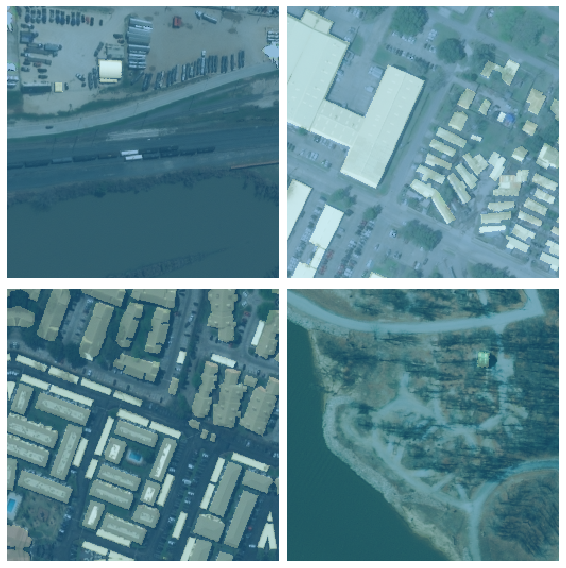

In [6]:
data.show_batch()

In [7]:
FocalLossBinary??

In [15]:
def to_onehot(indices, num_classes):
    """Convert a tensor of indices of any shape `(N, ...)` to a
    tensor of one-hot indicators of shape `(N, num_classes, ...) and of type uint8. Output's device is equal to the
    input's device`.
    """
    onehot = torch.zeros(indices.shape[0], num_classes, *indices.shape[1:],
#                              dtype=torch.uint8,
                         device=indices.device)
    return onehot.scatter_(1, indices.unsqueeze(1), 1)
class CombinedLoss(nn.Module):

    def __init__(self, gamma=2., alpha=0.25):
        super(CombinedLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, input, target, **kwargs):
        y = to_onehot(target, input.size(-1))
        logit = F.softmax(input)
                     
        focal_loss = FocalLossMultiClass(gamma=self.gamma, alpha=self.alpha) 
#         bce_dice = BCEDiceLoss()
        lovaz_loss = LovaszLossBinary()
#         dice_loss = DiceLoss(activation='Softmax')
        
        total_loss = focal_loss(logit, target) #+ 0.2 * lovaz_loss(logit, target)
        return total_loss

In [8]:
# model_deeplab =torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True, progress=True)
# device = torch.device("cuda")
# model_deeplab.to(device)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


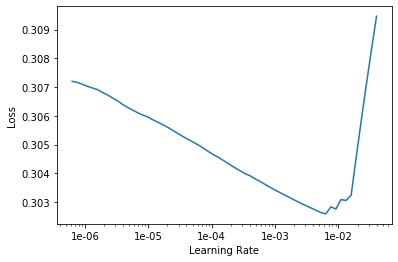

In [16]:
accuracy_pixel=partial(foreground_acc, void_code=0)
loss_fn = CombinedLoss()
wd =1e-2

metrics = [accuracy_pixel, dice]
# learn = Learner(data,deeplabv3_resnet101(num_classes=2),metrics=metrics)

learn = unet_learner(data, models.resnet34, metrics=metrics)
learn.loss_func = CombinedLoss()
learn.to_fp16();
learn.lr_find()
learn.recorder.plot(skip_end=0)



In [17]:
lr=5e-4
models_path = data_dir / "models"
learn.model_dir = models_path
callbacks=[SaveModelCallback(learn, every='improvement', monitor='dice', name='xview_buildings_unet_res34_focal_dice'),
#           TerminateOnNaNCallback(),
           ReduceLROnPlateauCallback(learn, patience=1)
          ]

learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.299955,0.299953,0.509148,0.143198,04:42
1,0.299952,0.299950,0.427716,0.174500,04:45
2,0.299842,0.299823,0.368802,0.117276,04:43


In [19]:
# 'normal' crossentropy loss
del learn
gc.collect()
learn = unet_learner(data, models.resnet34, metrics=metrics)
learn.to_fp16()
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.153061,0.115734,0.565341,0.578612,05:07
1,0.111863,0.105862,0.808586,0.677418,05:08
2,0.092746,0.089879,0.747277,0.681342,05:05


In [20]:
# higher batch size
size=256
bs=16
data = (src.transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
del learn
gc.collect()
learn = unet_learner(data, models.resnet34, metrics=metrics)
learn.to_fp16()
learn.fit_one_cycle(3, slice(lr))

learn.data = data



epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.127978,0.119070,0.589211,0.562890,03:30
1,0.107964,0.096107,0.736632,0.666525,03:23
2,0.095533,0.092358,0.766321,0.677711,03:24


In [23]:
# BCE dice loss
class CustomLoss(nn.Module):

    def __init__(self, gamma=2., alpha=0.25):
        super(CustomLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, input, target, **kwargs):
        logits=input[:,1,:,:].float()
        labels = target.squeeze(1).float()
                     
        focal_loss = FocalLossBinary(gamma=self.gamma, alpha=self.alpha) 
        bce_dice = BCEDiceLoss()
        lovaz_loss = LovaszLossBinary()
        dice_loss = DiceLoss(activation='Softmax')
        
        total_loss = bce_dice(logits, labels) #+ 0.2 * lovaz_loss(logit, target)
        return total_loss
    
del learn
gc.collect()
learn = unet_learner(data, models.resnet34, metrics=metrics)
learn.loss_func = CustomLoss()
learn.to_fp16()
learn.fit_one_cycle(3, slice(lr))




epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.236654,0.212962,0.817176,0.620606,02:59
1,0.199387,0.185876,0.852647,0.665116,02:59
2,0.179538,0.170132,0.841284,0.693204,02:59


In [37]:
class CustomLoss(nn.Module):

    def __init__(self, dice=0.5, bce=0.5):
        super(CustomLoss, self).__init__()
        self.dice = dice
        self.bce = bce

    def forward(self, input, target, **kwargs):
        logits=input[:,1,:,:].float()
        labels = target.squeeze(1).float()
                     
        bce_dice = BCEDiceLoss(dice_weight=self.dice, bce_weight=self.bce)
        
        total_loss = bce_dice(logits, labels) #+ 0.2 * lovaz_loss(logit, target)
        return total_loss
    
for i in [0.2,0.4,0.6, 0.8]:
    print(f"dice:{i}, bce:{1-i}")
    del learn
    gc.collect()
    learn = unet_learner(data, models.resnet34, metrics=metrics)
    learn.loss_func = CustomLoss(dice=i, bce=1-i)
    learn.to_fp16()
    learn.fit_one_cycle(3, slice(lr))

dice:0.2, bce:0.8


epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.173518,0.163318,0.637490,0.609297,02:58
1,0.147396,0.135473,0.752159,0.664764,02:56
2,0.129892,0.127328,0.790447,0.689065,02:59


dice:0.4, bce:0.6


epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.226183,0.196881,0.676947,0.618219,02:59
1,0.180640,0.167811,0.764729,0.657731,02:53
2,0.162497,0.156725,0.745179,0.673537,02:53


dice:0.6, bce:0.4


epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.248531,0.223945,0.807082,0.637224,02:54
1,0.206244,0.196067,0.825178,0.673877,02:53
2,0.190568,0.182515,0.815849,0.691087,02:53


dice:0.8, bce:0.19999999999999996


epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.288977,0.250591,0.791665,0.624502,02:54
1,0.229770,0.217079,0.792717,0.669194,02:52
2,0.207469,0.201562,0.801434,0.692409,02:52


In [33]:
# Focal loss again (I think I might have made a mistake?)
from catalyst.dl.utils.criterion.focal import sigmoid_focal_loss
class CustomLoss(nn.Module):

    def __init__(self, gamma=2., alpha=0.25):
        super(CustomLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, input, target, **kwargs):
        print(input.shape, target.shape)
        logits=input[:,1,:,:].float()
#         labels = target.squeeze(1).float()
        
        total_loss = sigmoid_focal_loss(input, target) #+ 0.2 * lovaz_loss(logit, target)
        return total_loss
    
del learn
gc.collect()
learn = unet_learner(data, models.resnet34, metrics=metrics)
learn.loss_func = CustomLoss()
learn.to_fp16()
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,foreground_acc,dice,time


torch.Size([16, 2, 256, 256]) torch.Size([16, 1, 256, 256])


ValueError: Target size (torch.Size([16, 1, 256, 256])) must be the same as input size (torch.Size([16, 2, 256, 256]))

In [35]:
# bce + lovaz 
class CustomLoss(nn.Module):

    def __init__(self, gamma=2., alpha=0.25):
        super(CustomLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, input, target, **kwargs):
        logits=input[:,1,:,:].float()
        labels = target.squeeze(1).float()
                     
        
        bce_dice = BCEDiceLoss()
        lovaz_loss = LovaszLossBinary()
        dice_loss = DiceLoss(activation='Softmax')
        bce_loss = F.binary_cross_entropy_with_logits(logits, labels)
        return 0.2* lovaz_loss(logits, labels) + 0.8*bce_loss
    
del learn
gc.collect()
learn = unet_learner(data, models.resnet34, metrics=metrics)
learn.loss_func = CustomLoss()
learn.to_fp16()
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.320948,0.304249,0.787426,0.584227,02:58
1,0.269861,0.251769,0.734858,0.652576,03:00
2,0.246959,0.238867,0.777898,0.676120,03:01


In [ ]:
# dice
class CustomLoss(nn.Module):

    def __init__(self, gamma=2., alpha=0.25):
        super(CustomLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, input, target, **kwargs):
        logits=input[:,1,:,:].float()
        labels = target.squeeze(1).float()
                     
        dice_loss = DiceLoss(activation='Softmax')(logits, labels)
        return dice_loss
    
del learn
gc.collect()
learn = unet_learner(data, models.resnet34, metrics=metrics)
learn.loss_func = CustomLoss()
learn.to_fp16()
learn.fit_one_cycle(3, slice(lr))